In [59]:
pip install prophet -q

Note: you may need to restart the kernel to use updated packages.


In [68]:
pip install pyod -q

Note: you may need to restart the kernel to use updated packages.


In [97]:
pip install ruptures -q

Note: you may need to restart the kernel to use updated packages.


In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  
from utils import visual_3_sigma,visual_algo, visual_prophet,visual_ruptures,general_visual

In [125]:
df=pd.read_csv('AS002.csv')
df['From Date']=pd.to_datetime(df['From Date'])
df=df.set_index('From Date')
df=df[::15]
data=df[['PM2.5 (ug/m3)']].copy()
data=data.dropna()

In [127]:
data.head()

,PM2.5 (ug/m3)
From Date,
2020-12-28 12:00:00,105.00
2020-12-29 03:00:00,179.11
2020-12-29 18:00:00,103.75
2020-12-30 09:00:00,117.61
2020-12-31 00:00:00,106.00


Наш датасет “Time Series Air Quality Data of India” содержит временные ряды данных по качеству воздуха в различных регионах Индии.
- PM2.5 (ug/m³): Концентрация мелких частиц (≤2.5 мкм)- микрограмм на кубический метр.
- PM10 (ug/m³): Концентрация крупных частиц (≤10 мкм)- микрограмм на кубический метр.
- NO2 (ug/m³): Диоксид азота - микрограмм на кубический метр.
- SO2 (ug/m³): Диоксид серы - микрограмм на кубический метр.
- CO (mg/m³): Угарный газ - микрограмм на кубический метр.
- O3 (ug/m³): Озон - микрограмм на кубический метр.

<font size="6">1.Сравнение алгоритмов на детекции аномалий во временных рядах</font>

### Метод трёх сигм

В методе трёх сигм мы рассчитываем границы на уровне ±3σ от среднего значения. Если наблюдаемое значение выходит за эти границы, оно считается аномалией. Вероятность такого события для нормально распределённых данных составляет примерно 0,3%.

In [133]:
mean = data['PM2.5 (ug/m3)'].mean()
std_dev = data['PM2.5 (ug/m3)'].std()

lower_limit = mean - 3 * std_dev
upper_limit = mean + 3 * std_dev

data['anomaly_OD'] = 0  
data.loc[(data['PM2.5 (ug/m3)'] < lower_limit) | (data['PM2.5 (ug/m3)'] > upper_limit), 'anomaly_OD'] = 1

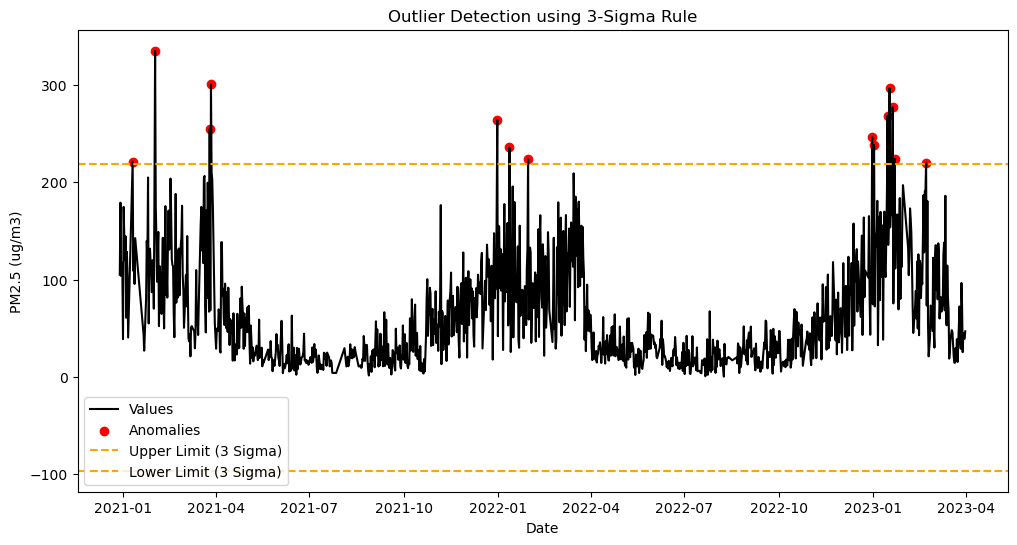

In [135]:
visual_3_sigma(data,'anomaly_OD',upper_limit,lower_limit)

### Isolation Forest

**PyOD** (Python Outlier Detection) — это библиотека для обнаружения аномалий, разработанная для упрощения работы с задачами по детекции выбросов в данных. Она поддерживает множество алгоритмов, включая статистические методы (например, Z-оценка и Grubbs' Test), методы машинного обучения (такие как Isolation Forest и k-Nearest Neighbors) и методы на основе нейронных сетей (например, AutoEncoder). 

Параметр **contamination** в алгоритмах обнаружения аномалий,указывает предполагаемую долю аномальных значений в данных. Этот параметр используется для настройки модели и позволяет алгоритму понять, какой процент наблюдений следует считать аномалиями. Во всех алгоритмах обнаружения аномалий мы будем считать, что параметр contamination равен 5%

In [140]:
from pyod.models.iforest import IForest

In [142]:
IF = IForest(contamination=0.05)
IF.fit(data)
data['anomaly_IF']=IF.predict(data)

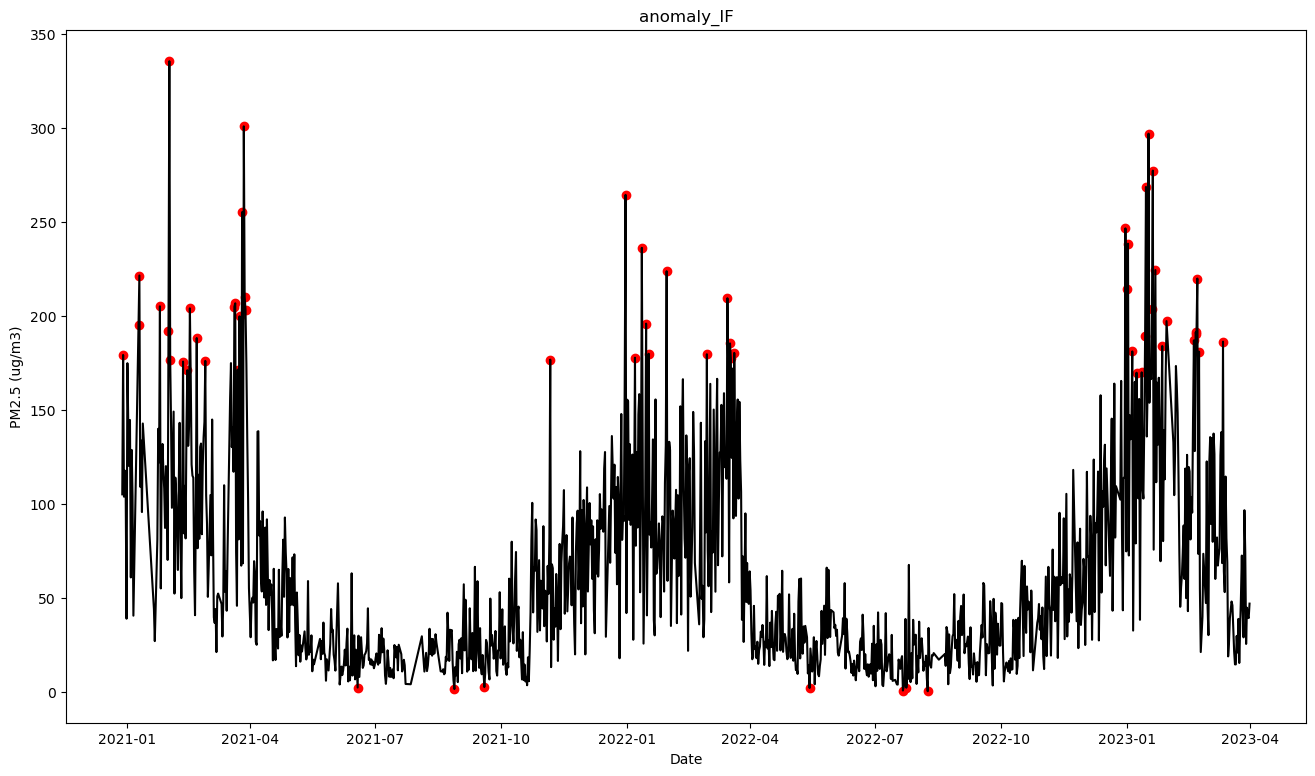

In [144]:
visual_algo(data,'anomaly_IF')

### EllipticEnvelope 

In [147]:
from sklearn.covariance import EllipticEnvelope

In [149]:
EE = EllipticEnvelope(contamination=0.05)
EE.fit(data[['PM2.5 (ug/m3)']])
data['anomaly_EE']=EE.predict(data[['PM2.5 (ug/m3)']])

In [151]:
data['anomaly_EE']=data['anomaly_EE'].map({-1:1,1:0})

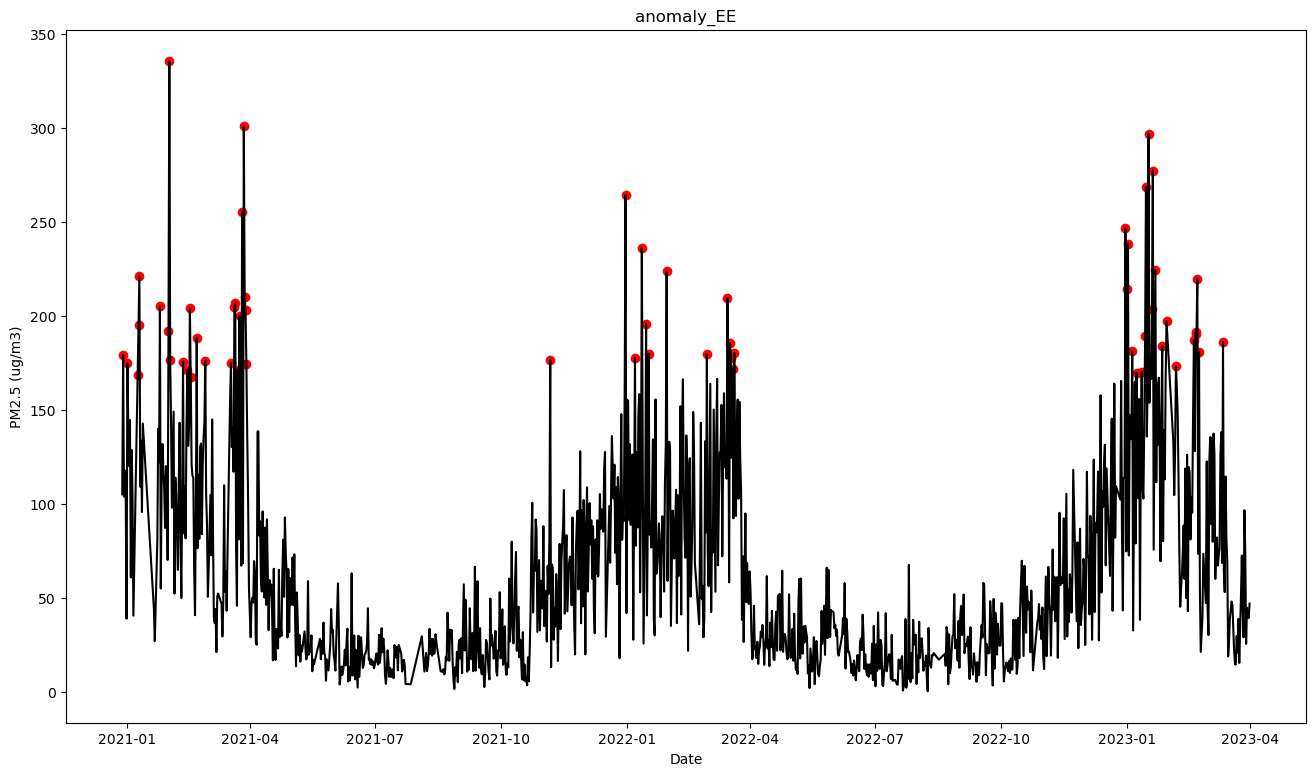

In [153]:
visual_algo(data,'anomaly_EE')

### LODA

In [156]:
from pyod.models.loda import LODA

In [158]:
LODA=LODA(contamination=0.05)
LODA.fit(data[['PM2.5 (ug/m3)']])
data['anomaly_LODA']=LODA.predict(data[['PM2.5 (ug/m3)']])

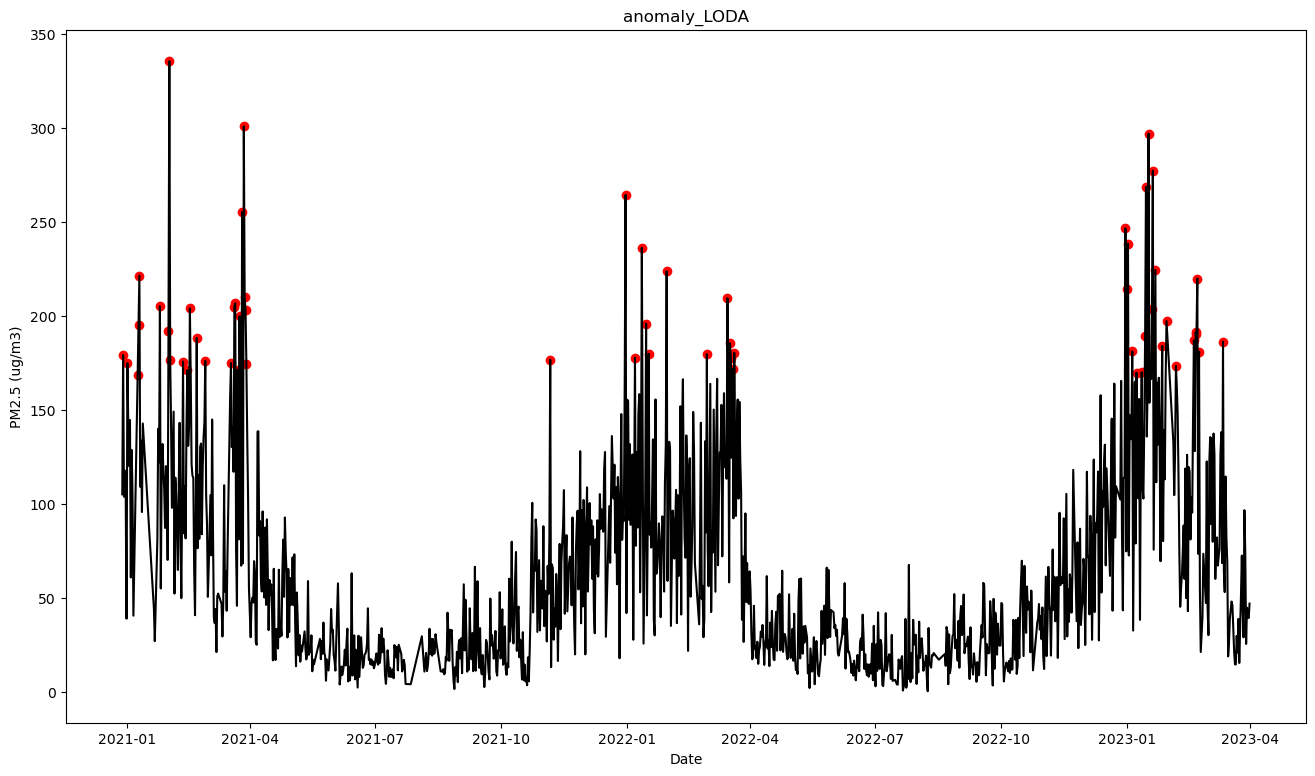

In [160]:
visual_algo(data,'anomaly_LODA')

### ABOD

Параметр **n_neighbors** в алгоритме ABOD(Angle-Based Outlier Detection) определяет количество ближайших соседей, используемых для вычисления углов между данными точками. Он задаёт, сколько ближайших соседей будет учитываться при анализе углов, формируемых между ними и целевой точкой. 

In [164]:
from pyod.models.abod import ABOD

In [166]:
abod=ABOD(contamination=0.05,n_neighbors=10)
abod.fit(data[['PM2.5 (ug/m3)']])
data['anomaly_ABOD']=abod.predict(data[['PM2.5 (ug/m3)']])


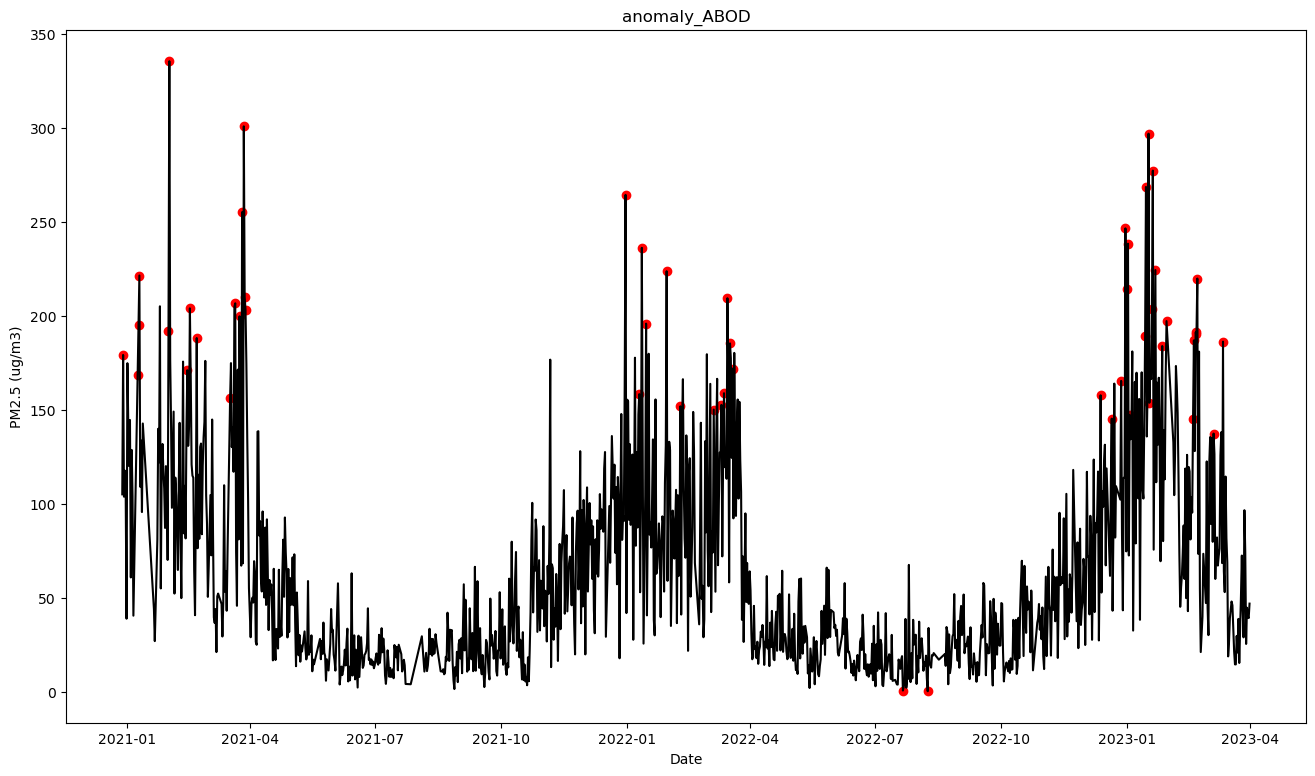

In [167]:
visual_algo(data,'anomaly_ABOD')

### Prophet

Для корректного использования библиотеки **Prophet** необходимо, чтобы данные имели определенные названия столбцов. Это упрощает обработку данных и гарантирует, что алгоритм будет правильно работать. 
1. Столбец с датами:
   - Должен называться **`ds`** (от "date stamp").
   - Данные в этом столбце должны быть в формате даты (например, `YYYY-MM-DD` или с временной меткой).
2. Столбец с целевыми значениями:
   - Должен называться **`y`** (от "target variable").
   - Данные в этом столбце должны представлять собой численные значения, которые вы хотите прогнозировать 



1. **Параметр `interval_width`**:
   - Этот параметр определяет ширину доверительного интервала для прогнозов.

2. **Метод `make_future_dataframe(periods=0)`**:
   - Этот метод используется для создания нового датафрейма, который включает будущие даты, для которых мы хотим сделать прогноз. Параметр `periods=0` указывает, что мы не добавляем новых периодов для прогноза, а используем только имеющиеся даты из нашего исходного набора данных.
3. **Добавление прогнозных значений**:
   - После выполнения прогнозирования мы добавляем результаты в наш датафрейм `prop_data`:
     - **`yhat`**: Этот столбец содержит предсказанные значения (центральные прогнозы) от модели.
     - **`yhat_upper`**: Этот столбец показывает верхнюю границу доверительного интервала, которая указывает на максимальные значения, которые модель считает возможными.
     - **`yhat_lower`**: Этот столбец представляет собой нижнюю границу доверительного интервала, показывая минимальные значения, которые модель считает возможными.

In [172]:
from prophet import Prophet

In [173]:
prop_data=data.reset_index().rename(columns={"From Date":'ds','PM2.5 (ug/m3)': 'y'})
prop_data=prop_data[['ds','y']]

In [177]:
Prop = Prophet(interval_width=0.95)
Prop.fit(prop_data)

03:07:56 - cmdstanpy - INFO - Chain [1] start processing
03:07:56 - cmdstanpy - INFO - Chain [1] done processing


In [178]:
future = Prop.make_future_dataframe(periods=0)
forecast = Prop.predict(future)

In [180]:
prop_data['yhat'] = forecast['yhat']
prop_data['yhat_upper'] = forecast['yhat_upper']
prop_data['yhat_lower'] = forecast['yhat_lower']


prop_data['anomaly'] = 0
prop_data.loc[(prop_data['y'] > prop_data['yhat_upper']) | (prop_data['y'] < prop_data['yhat_lower']), 'anomaly'] = 1

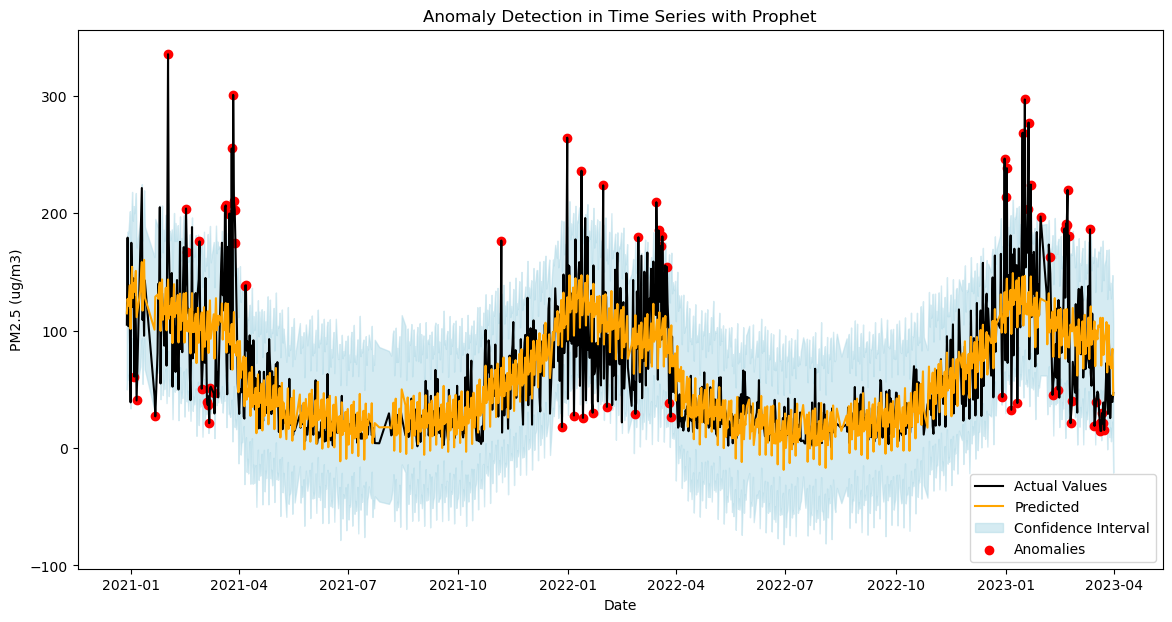

In [181]:
visual_prophet(prop_data,'anomaly')

In [182]:
prop_data = prop_data.reset_index(drop=True)
data = data.reset_index(drop=True)
data['anomaly_Prop']=prop_data['anomaly']
data=data.set_index(prop_data['ds'])

### LOF

In [186]:
from pyod.models.lof import LOF

In [188]:
lof=LOF(contamination=0.05)
lof.fit(data[['PM2.5 (ug/m3)']])
data['anomaly_LOF']=lof.predict(data[['PM2.5 (ug/m3)']])

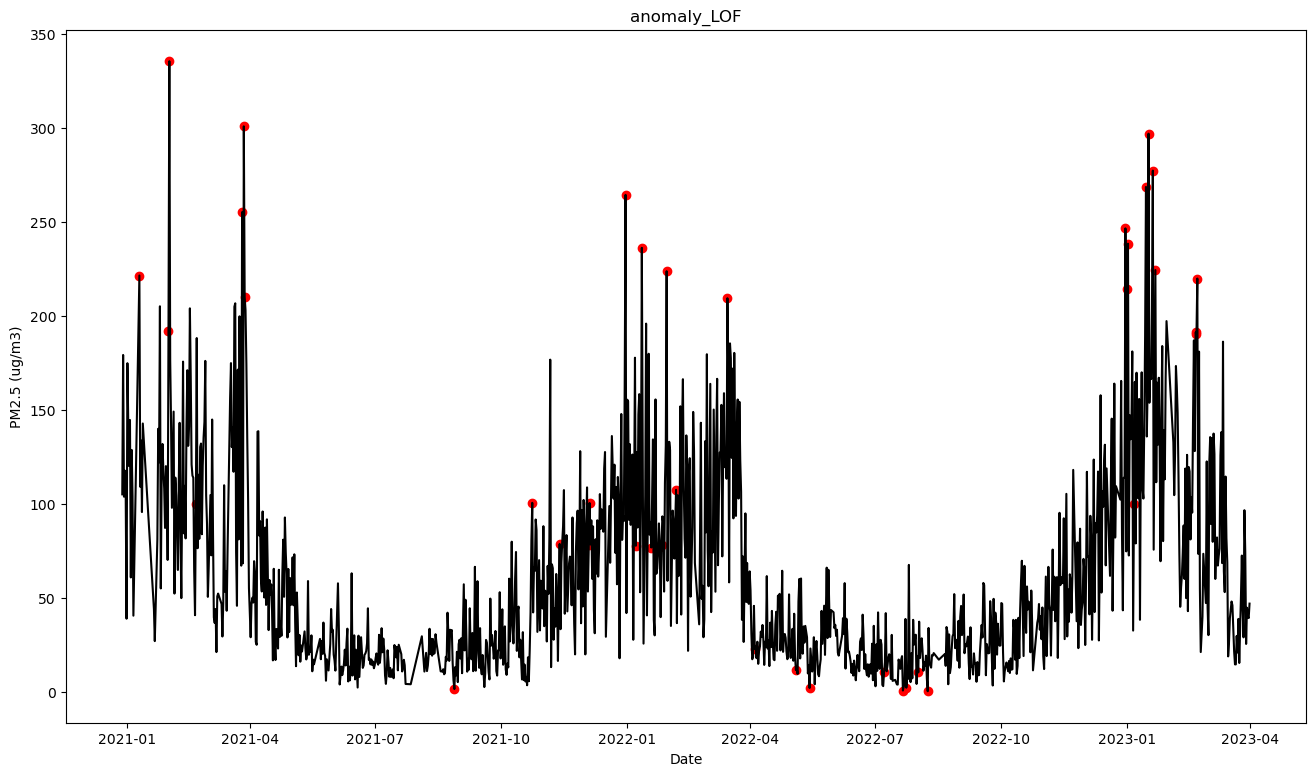

In [192]:
visual_algo(data, 'anomaly_LOF')

### HBOS

In [195]:
from pyod.models.hbos import HBOS

In [197]:
hbos = HBOS(contamination=0.05)
hbos.fit(data[['PM2.5 (ug/m3)']])
data['anomaly_HBOS']=hbos.predict(data[['PM2.5 (ug/m3)']])

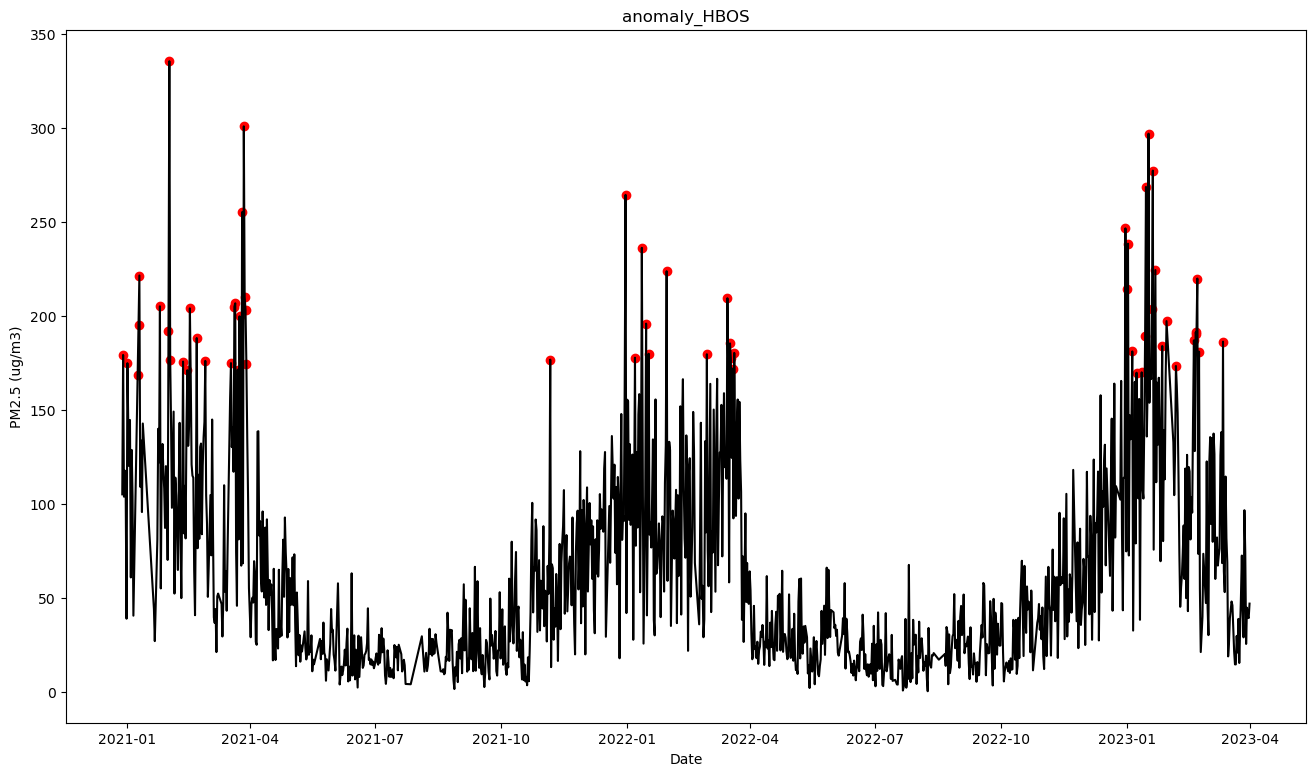

In [199]:
visual_algo(data, 'anomaly_HBOS')

### Ruptures

In [202]:
import ruptures as rpt

PELT — это метод для обнаружения точек разрыва (breakpoints) в временных рядах, который выявляет изменения в статистических свойствах данных (например, среднее значение, дисперсия). 
1. **model="rbf"**:
   - Параметр `model="rbf"` указывает на использование радиальной базисной функции (Radial Basis Function) для оценки стоимости разбиения.
   - RBF позволяет PELT выявлять разрывы в данных, где могут быть резкие изменения, и хорошо подходит для сложных временных рядов благодаря способности улавливать нелинейные зависимости.

2. **pen=10**:
   - Параметр `pen=10` задает штраф за добавление нового разрыва, что помогает избежать переобучения.
   - Слишком малый штраф может привести к слишком большому количеству разрывов, в то время как слишком большой может пропустить важные изменения.
   - Значение 10 указывает на баланс между чувствительностью к изменениям и устойчивостью к шуму в данных.

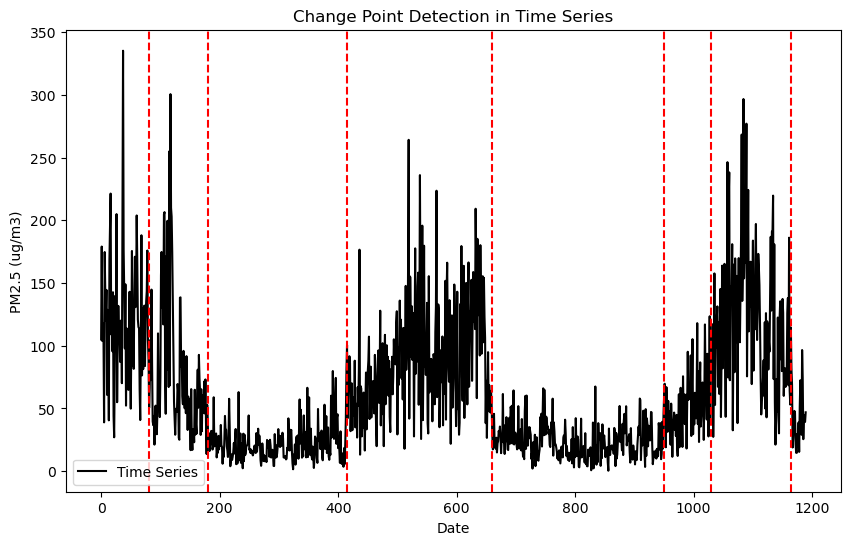

In [205]:
signal = data['PM2.5 (ug/m3)'].values

model = rpt.Pelt(model="rbf").fit(signal)

breakpoints = model.predict(pen=10) 

visual_ruptures(signal, breakpoints)

Мы разработали метрику для оценки влияния аномальных значений на общую вариацию данных, которая представляется следующей формулой:

$$
\text{Метрика} = \frac{\text{Общая вариация в данных}}{\text{Вариация в не аномальных данных}}
$$

Где:
- Общая вариация в данных — это стандартное отклонение для всех данных.
- Вариация в не аномальных данных — это стандартное отклонение, вычисленное только для нормальных значений (не аномалий).

Мы понимаем, что общая вариация в данных является константой. В то же время вариация в не аномальных данных должна уменьшаться, чтобы данные были более однородными. Это означает, что наша метрика должна максимизироваться, поскольку:

- **Общая вариация в данных** (const): остается неизменной и служит основой для сравнения.
- **Вариация в не аномальных данных**: стремится к уменьшению, что указывает на однородность данных.

Однако за значительное процентное количество аномалий метрика подвергается штрафу. Это означает, что, несмотря на стремление максимизировать метрику, высокое количество аномалий будет негативно сказываться на её значении. Таким образом, цель заключается в нахождении оптимального баланса между однородностью данных и количеством аномалий, что в конечном итоге способствует улучшению качества анализа и принятия решений.

In [208]:
def metrics(data,anomal,feature='PM2.5 (ug/m3)'):
    general_var=data[feature].std()
    not_anomaly_var=data[feature][data[anomal]==0].std()
    result=(general_var/not_anomaly_var)
    return result
    

In [211]:
for  i in data.columns:
         if i!='PM2.5 (ug/m3)':
             print(f'the result of {i}:{metrics(data,i)}')

the result of anomaly_OD:1.0922133246677808
the result of anomaly_IF:1.2423866336744172
the result of anomaly_EE:1.267143869095346
the result of anomaly_LODA:1.2635125643117906
the result of anomaly_ABOD:1.2079850588301992
the result of anomaly_Prop:1.1645866478481155
the result of anomaly_LOF:1.1126009122588205
the result of anomaly_HBOS:1.2635125643117906


### Посмотрим как отработали наши алгоритмы

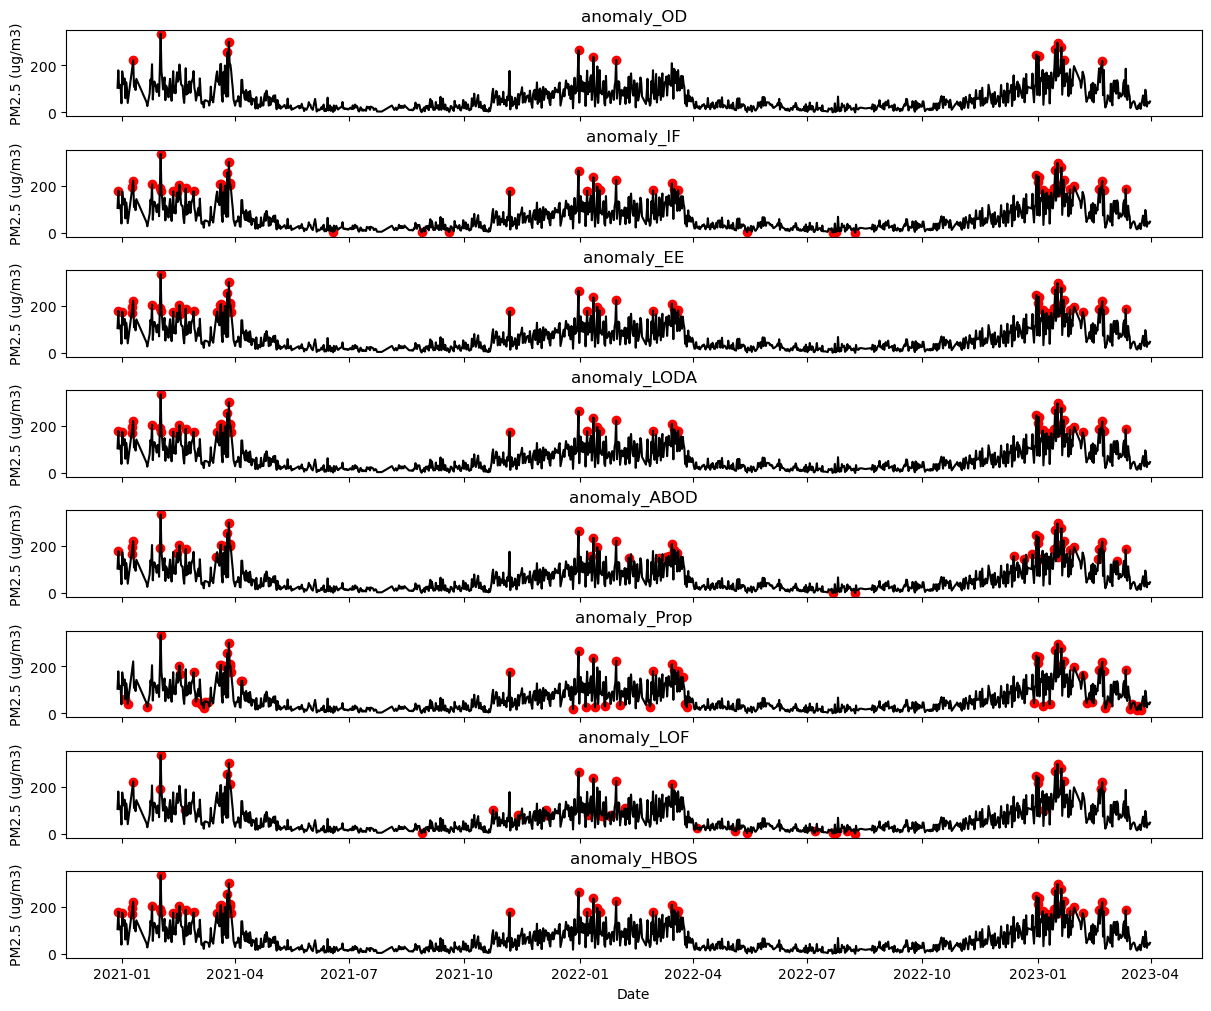

In [214]:
general_visual(data,data.columns)